In [1]:
import os
import itertools
import codecs
import re
import datetime
# import cairocffi as cairo
# import editdistance
import numpy as np
from scipy import ndimage
# import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import pathlib
import cv2

Using TensorFlow backend.


In [2]:


class TextImageGenerator(keras.callbacks.Callback):
    # 所有可能字符
    LABELS = '0123456789abcdefghijklmnopqrstuvwxyz '
    
    def __init__(self, train_path, validate_path, img_w, img_h, channel, downsample_factor, absolute_max_string_len=6):
        """
        Args:
            train_path: 训练数据路径
            validate_path: 验证图片路径
            img_w:
            img_h:
            downsample_factor: TODO 未知
            absolute_max_string_len: 最大字符串长度
        """
        self.img_w = img_w
        self.img_h = img_h
        self.channel = channel
        self.train_path = train_path
        self.validate_path = validate_path
        self.downsample_factor = downsample_factor
        self.blank_label = self.get_output_size() - 1
        self.absolute_max_string_len = absolute_max_string_len
        # 数据
        self.train_imgs = self.get_all_imgs(self.train_path)
        self.validate_imgs = self.get_all_imgs(self.validate_path)
        self.cur_idx = 0
        
        np.random.shuffle(self.train_imgs)
        np.random.shuffle(self.validate_imgs)
    
    def get_all_imgs(self, path):
#         p = pathlib.Path(path)
        # jpg or png
#         return list([str(i) for i in p.glob('*.jpg')])
        return [os.path.join(path, i) for i in os.listdir(path)]
    
    def get_output_size(self):
        return len(self.LABELS) + 1
    
    def char2idx(self, char):
        idx = self.LABELS.find(char)
        return idx if idx != -1 else self.blank_label
    
    @staticmethod
    def labels_to_text(labels):
        ret = []
        for c in labels:
            if c == len(TextImageGenerator.LABELS):  # CTC Blank
                ret.append("")
            else:
                ret.append(TextImageGenerator.LABELS[c])
        return "".join(ret)
    
    def path2matrix(self, path):
        """
        input shape: (batch_size, w, h, channel)
        """
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_transpose = np.einsum('hw->wh', img)
        img_transpose = np.expand_dims(img_transpose, axis=-1)
        return img_transpose

    def get_next_batch(self, paths, batch_size=32):
        def get_label(img_path):
            """
            获取验证码对应的字符串
            """
            return os.path.basename(img_path).split('.')[0].lower()
        i = 0
        X_data = np.zeros((batch_size, self.img_w, self.img_h, self.channel))
        labels = np.zeros((batch_size, self.absolute_max_string_len))
        input_length = np.zeros([batch_size, 1])
        label_length = np.zeros([batch_size, 1])
        source_str = []
        while i < batch_size:
            if self.cur_idx >= len(paths):
                # 归零，洗牌
                self.cur_idx = 0
                np.random.shuffle(paths)
            img_path = paths[self.cur_idx]
            label_text = get_label(img_path)
            X_data[i, :] = self.path2matrix(img_path)
            input_length[i] = self.img_w // self.downsample_factor - 2
            label_length[i] = len(label_text)
            labels[i] = [self.char2idx(char) for char in label_text]
            source_str.append(label_text)
            
            self.cur_idx += 1
            i += 1
            
        inputs = {
              'the_input': X_data,
              'the_labels': labels,
              'input_length': input_length,
              'label_length': label_length,
              'source_str': source_str  # used for visualization only
        }
        outputs = {'ctc': np.zeros([batch_size])}
        return (inputs, outputs)
            
    def get_next_train(self, batch_size=32):
        while True:
            yield self.get_next_batch(self.train_imgs, batch_size)
    
    def get_next_val(self, batch_size=32):
        while True:
            yield self.get_next_batch(self.validate_imgs, batch_size)
        


train_path = 'E:\\traindata\\captcha_create\\train'
validate_path = 'E:\\traindata\\captcha_create\\test'
test_img = os.path.join(train_path, '00ARLO.jpg')

img_w = 200
img_h = 60
channel = 1
downsample_factor = 4
img_gen = TextImageGenerator(train_path, validate_path, img_w, img_h, channel, downsample_factor)
# ret_input, ret_output = next(img_gen.get_next_train(3))
# ret_input, ret_output = next(img_gen.get_next_train(3))
# print(ret_input['the_input'].shape)
# print(ret_input['the_labels'])
# print(ret_input['input_length'])
# print(ret_input['label_length'])
# print(ret_input['source_str'])

In [3]:
# img_w = 200
# # Input Parameters
# img_h = 60
# channel = 1
# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 32
OUTPUT_DIR = 'E:\\Workplace\\bdzh\\MachineLearning\\SmallCaptcha\\image_ocr'


# the actual loss calc occurs here despite it not being
# an internal Keras loss function

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

if K.image_data_format() == 'channels_first':
    input_shape = (channel, img_w, img_h)
else:
    input_shape = (img_w, img_h, channel)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
base_model = Model(input=input_data, output=y_pred)
base_model.summary()

labels = Input(name='the_labels', shape=[img_gen.absolute_max_string_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)





Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 200, 60, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 60, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 100, 30, 16)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 100, 30, 16)  2320        max1[0][0]                       
_____________________________________

E:\scriptpath\visualstudio\shared\Anaconda3_64\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("th..., outputs=Tensor("so...)`


In [4]:

class VizCallback(keras.callbacks.Callback):

    def __init__(self, run_name, test_func, text_img_gen, num_display_words=6):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.text_img_gen = text_img_gen
        self.num_display_words = num_display_words
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def show_edit_distance(self, num):
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func, word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j], word_batch['source_str'][j])
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance: %.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
#         self.show_edit_distance(256)
        word_batch = next(self.text_img_gen)[0]
        res = decode_batch(self.test_func, word_batch['the_input'][0:self.num_display_words])
        if word_batch['the_input'][0].shape[0] < 256:
            cols = 2
        else:
            cols = 1
        for i in range(self.num_display_words):
            plt.subplot(self.num_display_words // cols, cols, i + 1)
            if K.image_data_format() == 'channels_first':
                the_input = word_batch['the_input'][i, 0, :, :]
            else:
                the_input = word_batch['the_input'][i, :, :, 0]
            plt.imshow(the_input.T, cmap='Greys_r')
            plt.xlabel('T = \'%s\' Decoed = \'%s\'' % (word_batch['source_str'][i], res[i]))
#             print(('Truth = \'%s\'\nDecoded = \'%s\'' % (word_batch['source_str'], res)))
#         plt.show()
#         fig = pylab.gcf()
#         fig = plt.figure(figsize=(30, 30))
#         fig.set_size_inches(10, 13)
        plt.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
        plt.close()

def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = TextImageGenerator.labels_to_text(out_best)
        ret.append(outstr)
    return ret

In [5]:
def evaluate(model, batch_num=50):
    batch_acc = 0
    generator = img_gen.get_next_val(batch_num)
    x_input, _  = next(generator)
    X_test = x_input['the_input']
    y_test = x_input['the_labels']
    y_pred = base_model.predict(X_test)[:, 2:, :]
    
    for i in range(batch_num):
#         [X_test, y_test, _, _]
        _X_test = X_test[i]
        _y_test = y_test[i]
        _y_pred = y_pred[i]
        _y_pred = np.expand_dims(_y_pred, axis=0)
        shape = _y_pred.shape
        ctc_decode = K.ctc_decode(_y_pred, 
                                  input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[0]
        if np.all(y_test == out):
            batch_acc += 1
            
        if i < 6:
            print('origin: %s, decoded: %s' % (_y_test, out))
    return batch_acc / batch_num

class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print()
        print('acc: %f%%'%acc)
evaluator = Evaluate()

In [6]:
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
# captures output of softmax so we can decode the output during visualization
test_func = K.function([input_data], [y_pred])

viz_cb = VizCallback(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'), test_func, img_gen.get_next_val())
model.fit_generator(generator=img_gen.get_next_train(100),
                    steps_per_epoch=120,
                    epochs=100,
                    validation_data=img_gen.get_next_val(1000),
                    validation_steps=5,
                    callbacks=[evaluator,],
                    verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
120/120 [==============================] - 134s 1s/step - loss: 36.0208 - val_loss: 27.3773
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
origin: [16.  7.  2. 34.  1. 28.], decoded: []


E:\scriptpath\visualstudio\shared\Anaconda3_64\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


origin: [10. 29.  1. 34. 23.  2.], decoded: []
origin: [21. 19. 13. 17. 24.  0.], decoded: []
origin: [21. 34. 16. 31. 16. 29.], decoded: []
origin: [ 4. 27. 10.  7. 24. 19.], decoded: []
origin: [14. 24.  0. 11. 15. 28.], decoded: []

acc: 0.000000%
Epoch 2/100
120/120 [==============================] - 33s 271ms/step - loss: 24.8175 - val_loss: 25.2930
origin: [25.  1.  7. 17.  9. 28.], decoded: [4]
origin: [19. 13.  9. 33. 12. 16.], decoded: [4]
origin: [ 9. 29. 30.  0. 24. 33.], decoded: [4]
origin: [16. 23. 19. 32. 19.  6.], decoded: [4]
origin: [24. 29. 10.  0. 21. 35.], decoded: [4]
origin: [19. 16. 31.  4. 29. 24.], decoded: [4]

acc: 0.000000%
Epoch 3/100
120/120 [==============================] - 34s 285ms/step - loss: 24.2587 - val_loss: 24.5237
origin: [ 1.  8. 11.  6. 16.  7.], decoded: [8]
origin: [ 1. 25. 34. 13. 18.  1.], decoded: [8]
origin: [ 9. 23. 10.  4. 24.  3.], decoded: [8]
origin: [31. 28.  3. 33. 20.  4.], decoded: [8]
origin: [10.  2. 24.  5. 12. 22.], decode

origin: [10.  3. 22. 19. 21. 28.], decoded: [16  4 34]

acc: 0.000000%
Epoch 21/100
120/120 [==============================] - 33s 273ms/step - loss: 22.4487 - val_loss: 22.4013
origin: [ 6. 29.  3.  5.  2. 22.], decoded: [ 7 24 24]
origin: [22. 22. 10. 33. 30. 16.], decoded: [ 7 24 24]
origin: [ 2. 24. 24. 30. 10.  0.], decoded: [ 7 24 24]
origin: [35.  1. 30.  9. 33. 13.], decoded: [ 7 24 24]
origin: [33.  4. 22. 10. 20.  0.], decoded: [ 7 24 24]
origin: [ 6. 16.  4. 11. 20. 18.], decoded: [ 7 24 24]

acc: 0.000000%
Epoch 22/100
120/120 [==============================] - 32s 270ms/step - loss: 22.7858 - val_loss: 22.5269
origin: [17. 14. 35. 11. 16. 19.], decoded: [ 7  3 24 24]
origin: [ 3. 28. 24. 35. 33.  7.], decoded: [ 7  3 24 24]
origin: [20.  2.  2. 21. 30. 10.], decoded: [ 7  3 24 24]
origin: [18.  0. 17.  3. 35. 23.], decoded: [ 7  3 24 24]
origin: [22. 27. 28.  1. 15. 11.], decoded: [ 7  3 24 24]
origin: [29. 21. 31. 18. 28. 25.], decoded: [ 7  3 24 24]

acc: 0.000000%
Epoch

origin: [11.  5. 15. 22. 35. 10.], decoded: []

acc: 0.000000%
Epoch 41/100
120/120 [==============================] - 34s 279ms/step - loss: 24.1485 - val_loss: 24.3384
origin: [28. 21. 24. 23. 31.  1.], decoded: []
origin: [16. 15.  4. 29. 24. 10.], decoded: []
origin: [32. 22.  0. 11. 23. 29.], decoded: []
origin: [35. 32. 15. 14. 12.  7.], decoded: []
origin: [ 1. 16.  0. 32. 27.  0.], decoded: []
origin: [21. 34. 16. 31. 16. 29.], decoded: []

acc: 0.000000%
Epoch 42/100
120/120 [==============================] - 33s 273ms/step - loss: 24.1388 - val_loss: 24.3235
origin: [ 1.  2. 33. 30. 30.  0.], decoded: []
origin: [21.  0. 19. 11. 24.  9.], decoded: []
origin: [10.  9. 35. 30. 20. 23.], decoded: []
origin: [25. 29. 11.  1. 15. 29.], decoded: []
origin: [ 9. 34.  6. 22. 15. 28.], decoded: []
origin: [24. 12. 24. 20.  5. 22.], decoded: []

acc: 0.000000%
Epoch 43/100
120/120 [==============================] - 34s 285ms/step - loss: 24.1286 - val_loss: 24.3399
origin: [31.  8. 13.

120/120 [==============================] - 33s 274ms/step - loss: 23.5069 - val_loss: 23.5344
origin: [35.  2.  2. 24. 13.  9.], decoded: []
origin: [13. 15. 31. 20. 14.  0.], decoded: []
origin: [17. 29.  5. 11. 33. 10.], decoded: []
origin: [ 0. 23. 24.  2. 29. 21.], decoded: []
origin: [ 5. 34. 30.  3.  1. 19.], decoded: []
origin: [ 2. 34. 31.  5. 22. 21.], decoded: []

acc: 0.000000%
Epoch 62/100
120/120 [==============================] - 33s 273ms/step - loss: 23.5024 - val_loss: 23.5429
origin: [34.  4.  5. 10.  6.  5.], decoded: []
origin: [34. 34. 30. 13.  2. 14.], decoded: []
origin: [33. 35.  1.  0. 29. 20.], decoded: []
origin: [ 6.  7.  7. 29. 32. 19.], decoded: []
origin: [ 7. 27. 18. 32. 14. 25.], decoded: []
origin: [14.  0.  5. 29.  3. 17.], decoded: []

acc: 0.000000%
Epoch 63/100
120/120 [==============================] - 40s 329ms/step - loss: 23.5019 - val_loss: 23.5433
origin: [15. 17. 25. 14.  7. 33.], decoded: []
origin: [20. 33. 16.  3.  0.  8.], decoded: []
or

origin: [ 3.  4. 28.  9. 29. 34.], decoded: []
origin: [ 1.  5. 17. 25. 32. 28.], decoded: []
origin: [35.  7.  4. 16. 24. 15.], decoded: []
origin: [ 5. 34.  0. 25. 31. 22.], decoded: []
origin: [29.  6.  6. 18. 14.  8.], decoded: []
origin: [32. 16. 21. 24. 35.  8.], decoded: []

acc: 0.000000%
Epoch 82/100
120/120 [==============================] - 122s 1s/step - loss: 23.7804 - val_loss: 23.8330
origin: [14.  3. 24.  1. 19.  4.], decoded: []
origin: [11. 32.  3.  3. 27. 18.], decoded: []
origin: [11. 25.  8.  8. 12. 21.], decoded: []
origin: [12.  0.  9.  3. 24.  5.], decoded: []
origin: [ 6. 10. 14. 18.  3. 24.], decoded: []
origin: [27.  3. 27.  5.  1. 32.], decoded: []

acc: 0.000000%
Epoch 83/100
120/120 [==============================] - 58s 480ms/step - loss: 23.7792 - val_loss: 23.8311
origin: [ 3. 23.  3. 24. 17.  0.], decoded: []
origin: [24.  2. 35. 24.  4. 32.], decoded: []
origin: [ 8. 19. 12. 21.  7. 29.], decoded: []
origin: [ 2.  1.  3.  4. 33. 24.], decoded: []
orig

(200, 60, 1)
(60, 200, 1)
(60, 200)
230.0
30.0
(12000,)


TypeError: Invalid dimensions for image data

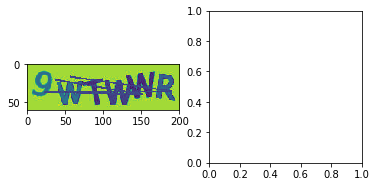

In [7]:
%matplotlib inline
generator = img_gen.get_next_val(2)
_x_input, _  = next(generator)
_X_test = _x_input['the_input']
_y_test = _x_input['the_labels']

img = _X_test[0]
print(img.shape)
print(np.einsum('hwc->whc', img).shape)
print(img[:, :, 0].T.shape)
print(np.max(img.flatten()))
print(np.min(img.flatten()))
print(_X_test[0].flatten().shape)
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 0].T)
plt.subplot(1, 2, 2)
img = np.einsum('hwc->whc', img)
plt.imshow(img)
plt.show()

# for i in range(_y_pred.shape[0]):
#     _y_pred = base_model.predict(np.expand_dims(_X_test[i], axis=0))[:, 2:, :]
#     print(_y_pred.shape)
#     for i in range(_y_pred.shape[0]):
#         __X_test = _X_test[i]
#         __y_test = _y_test[i]
#         __y_pred = _y_pred[i]
#         __y_pred = np.expand_dims(__y_pred, axis=0)
#         shape = __y_pred.shape
#         ctc_decode = K.ctc_decode(__y_pred, 
#                                   input_length=np.ones(shape[0])*shape[1])[0][0]
#         out = K.get_value(ctc_decode)[0]
#         print(out)


In [ ]:

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [10]:
model.save_weights('./weights/my_model_weights.h5')

OSError: Unable to create file (unable to open file: name = './weights/my_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)